In [1]:
import pickle
import yaml
import pandas as pd
import pickle
import sys
import numpy as np

import matplotlib.pyplot as plot

In [2]:
def loadConfig():    
    with open('./light_config_hulk.yaml', "r") as ymlfile: #hulk, slowloris; GE, heartbleed, slowhttp
        cfg = yaml.load(ymlfile)
    return cfg

config = loadConfig()

/home/wesleyjtann/miniconda3/envs/ddos/lib/python3.7/site-packages/ipykernel_launcher.py:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  This is separate from the ipykernel package so we can avoid doing imports until


In [3]:
import math

def calculateFalsePositives(agtIPList, agt_attacks, scoreDict, percentages, numNorm) :
    numNormal = numNorm
    numTotalIP = len(scoreDict)
    cutOff = []
    falsepositives = []
    
    for percent in percentages :
        cutOff.append(math.ceil(numTotalIP * percent))
    
    index = 0
    fp_count = 0 # add
    tp_count = 0 # add
    truepos = [] # add
    
    for (IP, IPD, score) in list(scoreDict.itertuples(index=False, name=None)):
        if IP + IPD in agtIPList: # add
            fp_count = fp_count + 1 # add
        if IP + IPD in agt_attacks:
            tp_count = tp_count + 1            
            
        index = index + 1
        if index in cutOff :
            falsepositives.append(fp_count/numNormal)
            truepos.append(tp_count / len(agt_attacks)) #len(agt_attacks)) # add
            
    return falsepositives, truepos
        
    
def plotAndSaveGraph(PQ, P, PQTil, classifier_rejectthres, fp_classifier, iter_classifier_one, iter_classifier, config, plt=False):
    percentages = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

    plot.rcParams['figure.figsize'] = [9, 9]
    fig = plot.figure()
    ax = plot.subplot(111)
    # #ax.plot(percentages, old_graphScoreList, label = "Old P Over Q Scores")
    # #ax.plot(percentages, old_graphPList, label = "Old P Scores")
    ax.plot(percentages, percentages, linewidth=2, label = "Randomized Rejection")
    ax.plot(percentages, P, linewidth=2, linestyle='--', marker='o', markersize=9, label = "N Only")
    ax.plot(percentages, PQ, linewidth=2, linestyle=':', label = "N/D (ℓ=1)") #With Transfer")
    ax.plot(percentages, PQTil, linewidth=2, linestyle='-.', label = "N/D (ℓ=∞)") #Without Transfer") 
#     ax.plot(percentages, Qonline, label = "Online Q")
#     ax.plot(percentages, Qoffline, label = "Offline Q") 
    ax.plot(percentages, iter_classifier_one, linewidth=2, linestyle='--', label = "Iter. Classifier (ℓ=1)") #Without Transfer")
    ax.plot(percentages, iter_classifier, linewidth=2, linestyle='--', marker='s', markersize=9, label = "Iter. Classifier (ℓ=∞)") #Without Transfer")
#     ax.plot(percentages, fp_classifier, linewidth=2, label = "Classifier") #Without Transfer")
    ax.plot(classifier_rejectthres,fp_classifier,'rx',markersize=15,markeredgewidth=5, label = "Full Classifier") 
    
#     plot.xlabel('Rejection Threshold', fontsize=24)
#     plot.ylabel('False Reject Rates', fontsize=24)
#     plot.title("False Positive rates for " + config['metadata']['name'])
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.legend(fontsize=18)
    if plt:
        plot.savefig(config['metadata']['uniqueID'] + '/' + config['metadata']['result'] + '_FPGraph')

def calc_eval(fpr, tpr, agt_norm, agt_attk):
    fpr = np.array(fpr[1:])
    tpr = np.array(tpr)

    Total = len(agt_norm)+len(agt_attk) #len(userScoreP)
    TotalN = len(agt_norm)
    TotalP = Total-TotalN
    FP = fpr*TotalN
    TN = TotalN - FP
    TP = tpr*TotalP
    FN = TotalP-TP
    
    Accr = (TP+TN) / (TP+TN+FP+FN)
    FPR = FP / (FP + TN)
    Prec = TP / (TP + FP)
    Rec = TP / (TP + FN)
    F1 = 2 * ((Prec*Rec) / (Prec+Rec))

    return (Accr, FPR, Prec, Rec, F1)

### Test set

In [4]:
# #Load User Scores
userScoreP = pickle.load(open(config['metadata']['uniqueID'] + '/' + config['metadata']['artefact'] + '/' + 'PScore', 'rb'))
userScoreP = userScoreP.sort_values(by = ['P'],ascending=True) # add

userScorePQ_online = pickle.load(open(config['metadata']['uniqueID'] + '/' + config['metadata']['artefact'] + '/' + 'PoverQonline_score', 'rb'))
userScorePQ_online = userScorePQ_online.sort_values(by = ['PoverQ_online'],ascending=True) # add 

userScorePQ_offline = pickle.load(open(config['metadata']['uniqueID'] + '/' + config['metadata']['artefact'] + '/' + 'PoverQoffline_score', 'rb'))
userScorePQ_offline = userScorePQ_offline.sort_values(by = ['PoverQ_offline'],ascending=True) 

# userScoreQonline = pickle.load(open(config['metadata']['uniqueID'] + '/' + config['metadata']['artefact'] + '/' + 'onlineQ', 'rb'))
# userScoreQonline = userScoreQonline.sort_values(by = ['QWithT'],ascending=True)

# userScoreQoffline = pickle.load(open(config['metadata']['uniqueID'] + '/' + config['metadata']['artefact'] + '/' + 'offlineQ', 'rb'))
# userScoreQoffline = userScoreQoffline.sort_values(by = ['QWithoutT'],ascending=True)

print("Length of userScoreP: ", len(userScoreP))

Length of userScoreP:  11710


In [5]:
len(userScoreP)

11710

In [6]:
import matplotlib.pyplot as plt
attacker='172.16.0.1'; victim='192.168.10.50'

# def showscore(scoretype, scores):
#     fig = plt.figure(figsize=(7,5))
#     plt.hist(scoretype[scores].sort_values()[scoretype['Source IP'] == victim], bins=20, alpha=0.5, label='victim') 
#     plt.hist(scoretype[scores].sort_values()[scoretype['Source IP'] == attacker], bins=20, alpha=0.5, label='attcker')
#     plt.legend(loc='upper right')
#     plt.show()
def showscore(scoretype, scores):
    fig = plt.figure(figsize=(7,5))
    plt.hist(scoretype[scores][scoretype['Source IP'] != attacker], bins=10, alpha=0.5, label='victim') 
    plt.hist(scoretype[scores][scoretype['Source IP'] == attacker], bins=10, alpha=0.5, label='attcker')
    plt.legend(loc='upper right')
    plt.show()
    return fig

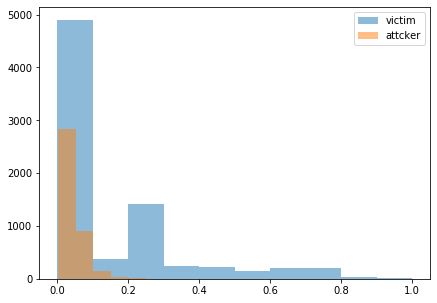

In [7]:
# add standardization
std_userScoreP = userScoreP
std_userScoreP['P'] = (std_userScoreP['P'] - std_userScoreP['P'].min(axis=0)) / (std_userScoreP['P'].max(axis=0) - std_userScoreP['P'].min(axis=0))

fig = showscore(userScoreP, 'P') # P scores

# fig.savefig('./' + config['metadata']['uniqueID'] + '/' + config['metadata']['result'] + '_P_distr' + '.png')

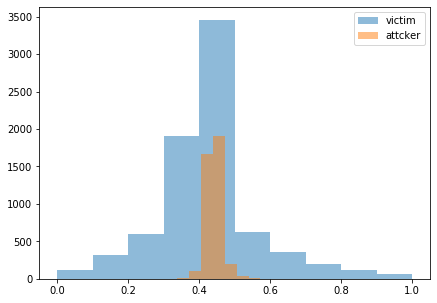

In [8]:
# add standardization
std_userScorePQ_online = userScorePQ_online
std_userScorePQ_online['PoverQ_online'] = (std_userScorePQ_online['PoverQ_online'] - std_userScorePQ_online['PoverQ_online'].min(axis=0)) / (std_userScorePQ_online['PoverQ_online'].max(axis=0) - std_userScorePQ_online['PoverQ_online'].min(axis=0))

fig = showscore(std_userScorePQ_online, 'PoverQ_online') # online Q

# fig.savefig('./' + config['metadata']['uniqueID'] + '/' + config['metadata']['result'] + '_PQonline_distr' + '.png')

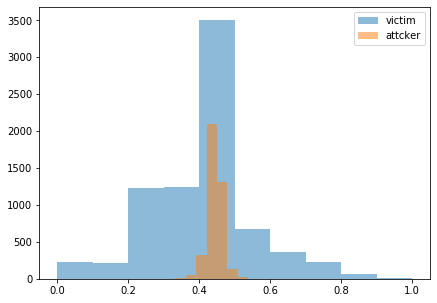

In [9]:
# add standardization
std_userScorePQ_offline = userScorePQ_offline
std_userScorePQ_offline['PoverQ_offline'] = (std_userScorePQ_offline['PoverQ_offline'] - std_userScorePQ_offline['PoverQ_offline'].min(axis=0)) / (std_userScorePQ_offline['PoverQ_offline'].max(axis=0) - std_userScorePQ_offline['PoverQ_offline'].min(axis=0))

fig = showscore(std_userScorePQ_offline, 'PoverQ_offline') # offline Q

# fig.savefig('./' + config['metadata']['uniqueID'] + '/' + config['metadata']['result'] + '_PQoffline_distr' + '.png')

### Predicted P-only user scores

In [10]:
print("Length of userScoreP: ", len(userScoreP))

Length of userScoreP:  11710


In [7]:
agt_normals = []
agt_attacks = []
attacker='172.16.0.1'; victim='192.168.10.50'
print("Length of userScoreP: ", len(userScoreP))

for (IP, IPD, score) in list(userScoreP.itertuples(index=False, name=None)):
#     if (IP != '172.16.0.1' and  IPD=='192.168.10.50') or IP == '192.168.10.50': 
#     if (IP != attacker and  IPD==victim) or IP == victim: 
    if IP == attacker or IP == victim:
        agt_attacks.append(IP+IPD)
    else:
        agt_normals.append(IP + IPD)
        

print("Length of Normal traffic: ", len(agt_normals))
print("Length of true attacks: ", len(agt_attacks))

#Plot some graphs
percentages = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

num = len(agt_normals)
print("Percent attacks: ", len(agt_attacks)/len(userScoreP))

Length of userScoreP:  11710
Length of Normal traffic:  4552
Length of true attacks:  7158
Percent attacks:  0.611272416737831


In [12]:
# HULK
# Length of test data:  11710
# Number of normal traffic:  4552
# Number of true attacks:  7158
# Percent attacks:  0.611272416737831

classifier_rejectthres = 0.6 #0.5099
fp_classifier = 0.028119507908611598 #0.007249560632688928

# (ℓ = ∞)
iter_classifier = [0,
 0.011251354624848602,
 0.014502454261490405,
 0.016924842226047045,
 0.01855039204436795,
 0.02084528590552687,
 0.022662076878944348,
 0.024797603110856124,
 0.028144323325046218,
 0.03394530502964238,
 1.0]

## OLD
# iter_classifier = [0,
#  0.01296133567662566,
#  0.014279437609841827,
#  0.015377855887521968,
#  0.01603690685413005,
#  0.016476274165202108,
#  0.016915641476274165,
#  0.018233743409490334,
#  0.018892794376098417,
#  0.021748681898066783,
#  1.0]

In [13]:
# HULK
# (ℓ = 1)
iter_classifier_one = [0,
 0.023554535602728372,
 0.028941161471281954,
 0.03235162873717091,
 0.03522024606361956,
 0.0378657487091222,
 0.04159495123350545,
 0.04459106266335182,
 0.04937209154076624,
 0.05756358768406961,
 1.0]

## OLD
# iter_classifier_one =  [0,
#  0.018892794376098417,
#  0.01999121265377856,
#  0.02482425307557118,
#  0.03031634446397188,
#  0.03492970123022847,
#  0.04173989455184534,
#  0.045035149384885766,
#  0.0632688927943761,
#  0.08369947275922672,
#  1.0]

In [10]:
graphP, P_tpr = calculateFalsePositives(agt_normals, agt_attacks, userScoreP, percentages, num)
graphPQ_online, onlinePQ_tpr = calculateFalsePositives(agt_normals, agt_attacks, userScorePQ_online, percentages, num)
graphPQ_offline, offlinePQ_tpr  = calculateFalsePositives(agt_normals, agt_attacks, userScorePQ_offline, percentages, num)
# graphQonline, _ = calculateFalsePositives(agt_normals, agt_attacks, userScoreQonline, percentages, num)
# graphQoffline, _ = calculateFalsePositives(agt_normals, agt_attacks, userScoreQoffline, percentages, num)   

graphP.insert(0, 0)
graphPQ_online.insert(0, 0)
graphPQ_offline.insert(0, 0)
# graphQonline.insert(0, 0)
# graphQoffline.insert(0, 0)

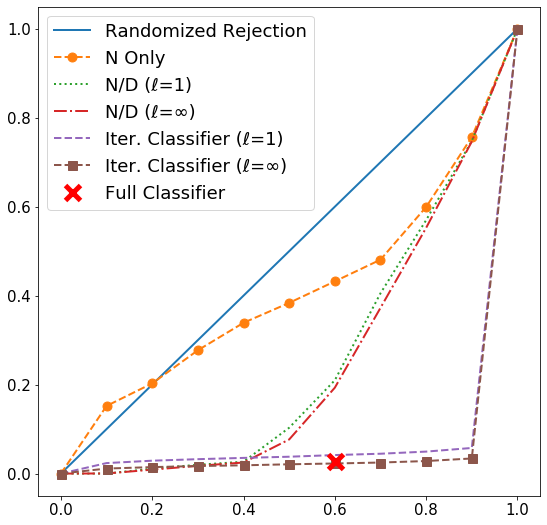

In [16]:
plotAndSaveGraph(graphPQ_online, graphP, graphPQ_offline, 
                 classifier_rejectthres, fp_classifier, iter_classifier_one, iter_classifier, config) #, plt=True)

### Calculate evaluation metrics 

In [23]:
P_metrics = np.array(np.transpose(calc_eval(graphP, P_tpr, agt_normals, agt_attacks)))
onlinePQ_metrics = np.array(np.transpose(calc_eval(graphPQ_online, onlinePQ_tpr, agt_normals, agt_attacks)))
offlinePQ_metrics = np.array(np.transpose(calc_eval(graphPQ_offline, offlinePQ_tpr, agt_normals, agt_attacks)))

P_metrics = pd.DataFrame(P_metrics, columns=['Accr_P', 'FPR_P', 'Prec_P', 'Rec_P', 'F1_P'])
onlinePQ_metrics = pd.DataFrame(onlinePQ_metrics, columns=['Accr_onPQ', 'FPR_onPQ', 
                                                           'Prec_onPQ', 'Rec_onPQ', 'F1_onPQ'])
offlinePQ_metrics = pd.DataFrame(offlinePQ_metrics, columns=['Accr_offPQ', 'FPR_offPQ', 
                                                             'Prec_offPQ', 'Rec_offPQ', 'F1_offPQ'])
df_FPresults = pd.concat([P_metrics,onlinePQ_metrics,offlinePQ_metrics],axis=1)

# df_FPresults.to_csv(config['metadata']['uniqueID'] + '/' + config['metadata']['result'] + 
#                     "_evalresults.csv", index=False)

In [21]:
# Rows 3=0.4, 4=0.5, 5=0.6
df_FPresults#.iloc[4]

,Accr_P,FPR_P,Prec_P,Rec_P,F1_P,Accr_onPQ,FPR_onPQ,Prec_onPQ,Rec_onPQ,F1_onPQ,Accr_offPQ,FPR_offPQ,Prec_offPQ,Rec_offPQ,F1_offPQ
0,0.370538,0.152021,0.409052,0.066918,0.115020,0.488728,0.000000,1.000000,0.163593,0.281186,0.488557,0.000220,0.999146,0.163453,0.280946
1,0.431085,0.202768,0.605892,0.198240,0.298737,0.580188,0.010984,0.978651,0.320201,0.482526,0.581896,0.008787,0.982921,0.321598,0.484632
2,0.473185,0.277241,0.640763,0.314473,0.421891,0.673356,0.019772,0.974381,0.478206,0.641552,0.675235,0.017355,0.977512,0.479743,0.643614
3,0.525192,0.338972,0.670581,0.438810,0.530485,0.768061,0.026582,0.974167,0.637469,0.770647,0.769428,0.024824,0.975875,0.638586,0.771998
4,0.590350,0.383787,0.701623,0.573903,0.631369,0.808625,0.103032,0.919898,0.752445,0.827788,0.829120,0.076670,0.940393,0.769209,0.846231
5,0.652775,0.432118,0.720040,0.706762,0.713339,0.825619,0.209798,0.864076,0.848142,0.856035,0.838599,0.193102,0.874893,0.858759,0.866751
6,0.714859,0.480888,0.732951,0.839341,0.782546,0.773612,0.405316,0.774918,0.887399,0.827353,0.799061,0.372583,0.793095,0.908215,0.846760
7,0.722801,0.599297,0.708796,0.927633,0.803582,0.745687,0.569859,0.723100,0.946354,0.819799,0.759180,0.552504,0.731533,0.957390,0.829360
8,0.700512,0.756591,0.673214,0.991199,0.801831,0.707344,0.747803,0.677009,0.996787,0.806351,0.708369,0.746485,0.677579,0.997625,0.807029
9,0.611272,1.000000,0.611272,1.000000,0.758745,0.611272,1.000000,0.611272,1.000000,0.758745,0.611272,1.000000,0.611272,1.000000,0.758745


In [ ]:
# reject 50%
df_FPresults.iloc[4]

### Calculate evaluation metrics 

In [ ]:
fpr=graphP; tpr=P_tpr
# fpr=graphPQ_online; tpr=onlinePQ_tpr
# fpr=graphPQ_offline; tpr=offlinePQ_tpr

In [ ]:
tau = 5 #3=0.4, 4=0.5, 5=0.6
fpr = np.array(fpr[1:])
tpr = np.array(tpr)

Total = len(agt_normals)+len(agt_attacks) #len(userScoreP)
TotalN = len(agt_normals)
TotalP = Total-TotalN
FP = fpr*TotalN
TN = TotalN - FP
TP = tpr*TotalP
FN = TotalP-TP

print(Total, TotalN, TotalP, FP[tau], TN[tau], TP[tau], FN[tau])

In [ ]:
Accr = (TP+TN) / (TP+TN+FP+FN)
FPR = FP / (FP + TN)
Prec = TP / (TP + FP)
Rec = TP / (TP + FN)
F1 = 2 * ((Prec*Rec) / (Prec+Rec))

print(Accr[tau], FPR[tau], Prec[tau], Rec[tau], F1[tau])

In [ ]:
graphP = np.array(graphP)
graphPQ= np.array(graphPQ_online)
graphPQTil= np.array(graphPQ_offline)

df_FPresults = pd.DataFrame({"P_FP":graphP[1:], "OnlineQ_FP":graphPQ[1:], "OfflineQ_FP":graphPQTil[1:], 
                             "Accr":Accr, "FPR":FPR, "Precision":Prec, 
                             "Recall":Rec, "F1_score":F1})

# df_FPresults.to_csv(config['metadata']['uniqueID'] + '/' + config['metadata']['result'] + 
#                     "_FP_finalresults.csv", index=False)

In [ ]:
df_FPresults